# Problem loan prediction 2017 - Lending Club
## Code
### For more information about the results of this project, check the report.pdf file

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline
l_encoder = LabelEncoder()

## Uploading the data

The data was dowloaded from the Lending Club website in two files, one for each quarter.

Uploading each file separately and then merging it into a single pandas data frame.

In [ ]:
# Uploading data into two dataframes

data_1Q = pd.read_csv('LoanStats_2017Q1.csv', skiprows=1, low_memory=False)
data_2Q = pd.read_csv('LoanStats3a.csv', skiprows=1, low_memory=False)

# Merging the dataframes

data_loans = pd.concat([data_1Q, data_2Q])

In [ ]:
print (data_loans.shape)
print('HEAD')
display(data_loans.head())
print('\n TAIL')
display(data_loans.tail())

There are a few data descriptors at the end of the files than need to be remove. 

In [ ]:
data_loans = data_loans.sort_values(by = 'id',na_position = 'first', ascending=True)
display(data_loans.tail(10))

In [ ]:
print ('The data frame has %d rows (loans) with %d columns' % (data_loans.shape[0], data_loans.shape[1]))
data_loans.drop(data_loans.tail(5).index,inplace=True)
display(data_loans.tail(5))

Remove the columns with only NaN and or with large number of NaN

In [ ]:
# Create df with number of NaN on each column
use_col = pd.DataFrame(data_loans.isnull().sum().sort_values())
use_col.reset_index(drop = False, inplace=True)
use_col.columns = (['col_name','num_NaN'])
display(use_col)

In [ ]:
pd.DataFrame(data_loans.isnull().sum().sort_values()[data_loans.isnull().sum().sort_values()<10])

In [ ]:
data_loans = data_loans.dropna(axis=1, how='all')
data_loans.shape

In [ ]:
def df_col_low_nan(df_data, min_nan): 
    # Returns a df with columns with less nan than min_nan
    use_col = pd.DataFrame(df_data.isnull().sum().sort_values()[df_data.isnull().sum().sort_values()<min_nan])
    use_col.reset_index(drop = False, inplace=True)
    use_col.columns = (['col_name','num_NaN'])
    new_data = pd.DataFrame()
    for i in range(0,len(use_col.col_name)):
        df = df_data[use_col.col_name[i]]
        new_data = pd.concat([new_data, df], axis=1)
    return new_data


In [ ]:
n_loan_df = df_col_low_nan(data_loans, 10)
n_loan_df.shape

In [ ]:
#data_loans
#data_2017 = pd.read_csv('loans_2017.csv')
n_loan_df.to_csv('loans_2017.csv', index=False)

In [ ]:
n_loan_df = pd.read_csv('loans_2017.csv')
n_loan_df.shape

## Cleaning target feature (loan_status)

For the purpose of this project, problem loans are loans that have not been paid, and that have a been classified as:

Late, Grace period, Default, or Charged Off

In [ ]:
#n_loan_df = n_loan_df.filter(regex='loan_status')
n_loan_df.loan_status.unique()

In [ ]:
# Removing fully paid loans
n_loan_df = n_loan_df[n_loan_df.loan_status.str.contains('Current')==False]

# Collapsing all but Fully Paid into Problem Loan
n_loan_df.loan_status = n_loan_df.loan_status.str.replace(r'(^.*Paid$)', 'Fully Paid')
n_loan_df.loan_status = n_loan_df.loan_status.str.replace(r'(^.*Charged Off$)', 'Charged Off')
n_loan_df.loan_status = n_loan_df.loan_status.str.replace(r'(^Late.*$)', 'Late')
n_loan_df.loan_status = n_loan_df.loan_status.str.replace(r'(Late)|(Charged Off)|(In Grace Period)|(Default)', 
                                                          'Problem Loan')
n_loan_df.loan_status.unique()


## Feature cleaning and selection

In [ ]:
# Custom functiones needed later
def types_of_columns(df):
    # creates two separate dataframes 
    # one with float column names and the other with object column names
    non_num_cols = df.dtypes[df.dtypes == 'object']
    float_cols   = df.dtypes[df.dtypes != 'object']
    return non_num_cols, float_cols

def column_checker (df1, df2, num):
    # df1 dataframe whit the columns
    # df2 dataframe with colum names
    for col in range(0,len(df2)):
        col = df2.index[col]
        values = df1[col].unique()
        if len(values) > num:
           print('\n', col, '\n',len(values),'\n',values)

Sorting the columns by type

In [ ]:
col_types_original = types_of_columns(n_loan_df)

### Non-Numeric Features

In [ ]:
nn_col_list = col_types_original[0]
nn_col_list

In [ ]:
column_checker(n_loan_df, types_of_columns(n_loan_df)[0], 0)

#### Dropping columns with repetitive or non-relevant information

zip_code and addr_state have similar information - keeping addr_state

grade and sub_grade also have similar information - keeping grade

In [ ]:
# Dropping zip_code, sub_grade, and initial_list_status 
n_loan_df = n_loan_df.drop(["zip_code"], axis=1)
n_loan_df = n_loan_df.drop(["sub_grade"], axis=1)
n_loan_df = n_loan_df.drop(["initial_list_status"], axis=1)

Converting dates and other numbers into actual numeric variables

In [ ]:
# int_rate
n_loan_df.int_rate = n_loan_df.int_rate.str.replace('%', " ").astype(float)

# emp_length
# Removing 2110 rows with n/a in emp_length
n_loan_df = n_loan_df[n_loan_df.emp_length.str.contains('n/a')==False]
# less than one year is now 0
n_loan_df.emp_length = n_loan_df.emp_length.str.replace(r'( years)|( year)|(\+ years)', "").str.replace('< 1','0').astype(float)

# Dates
# issue_d is now delta time since issued
n_loan_df.issue_d = ((max(pd.to_datetime(n_loan_df['issue_d'])) - pd.to_datetime(n_loan_df['issue_d'])).dt.days/365).astype(int)

# last_credit_pull_d is now delta time since last credit check
n_loan_df.last_credit_pull_d = (max(pd.to_datetime(n_loan_df['last_credit_pull_d'])) - pd.to_datetime(n_loan_df['last_credit_pull_d'])).dt.days/365
n_loan_df.last_credit_pull_d = n_loan_df.last_credit_pull_d[n_loan_df.last_credit_pull_d.isnull()==False]
n_loan_df = n_loan_df[n_loan_df.last_credit_pull_d.isnull() == False]

In [ ]:
column_checker(n_loan_df, types_of_columns(n_loan_df)[0], 0)

In [ ]:
nn_col_list = types_of_columns(n_loan_df)[0].index.drop(['loan_status'])

row = 4
col = 3

fig, axs = pl.subplots(row,col, figsize=(20,30))
fig.subplots_adjust(wspace=0.5, hspace=0.25)

for num, name in enumerate(nn_col_list):
    #print (num, name)
    i = num%row
    j = num%col
    graph = sns.countplot(y = n_loan_df[name], hue=n_loan_df['loan_status'], ax = axs[i,j], linewidth = 1.5)
    graph.set(xlabel=name, ylabel='')

In [ ]:
for col in nn_col_list:
    series = n_loan_df.groupby(col)['loan_status'].count()
    print ('\n',series)

### Numeric Features

In [ ]:
len(types_of_columns(n_loan_df)[1].index)

In [ ]:
num_col_list = types_of_columns(n_loan_df)[1].index

for col in num_col_list:
    length = len(n_loan_df[col].unique())
    print (col, length)

In [ ]:
# Column with a single value
n_loan_df = n_loan_df.drop(["policy_code"], axis =1)

# Columns with similar data
n_loan_df = n_loan_df.drop(["installment"], axis =1)
n_loan_df = n_loan_df.drop(["funded_amnt"], axis =1)
n_loan_df = n_loan_df.drop(["funded_amnt_inv"], axis =1)
n_loan_df = n_loan_df.drop(["out_prncp_inv"], axis =1)

In [ ]:
num_col_list = types_of_columns(n_loan_df)[1].index

cor_df = pd.DataFrame()
for i in range(0,len(num_col_list)):
    cor_df = pd.concat([cor_df, n_loan_df[num_col_list[i]]],axis=1)    

In [ ]:
n_loan_df.dtypes

In [ ]:
f, ax = pl.subplots(figsize=(10, 8))
corr = cor_df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(250, 15, as_cmap=True),
            square=True, ax=ax, annot=True, vmin=0, vmax=1, linewidths=2, xticklabels=1, yticklabels=True)

In [ ]:
row1 = 4
col1 = 4

fig, axs = pl.subplots(row1,col1, figsize=(20,15))
fig.subplots_adjust(wspace=0.5, hspace=0.25)

for num, name in enumerate(num_col_list):
    i = num//row1
    j = num%col1
    graph = sns.boxplot(y = n_loan_df[name], ax = axs[i,j], linewidth = 1.5)
    graph.set(xlabel=name, ylabel='')

In [ ]:
n_loan_df = n_loan_df[n_loan_df.annual_inc.isnull()==False]

Removing outgorups

In [ ]:
n_loans = n_loan_df.reset_index(drop=True)
# ADAPTE FROM CUSTOMER SEGMENTATION PROJECT
outliers_all = np.array([], dtype='int64')
for column in types_of_columns(n_loans)[1].index:
    Q1 = np.percentile(n_loans[column], 25)
    Q3 = np.percentile(n_loans[column], 75)
    step = (Q3 - Q1)*2
    out_list_feat=list(n_loans[~((n_loans[column] >= Q1 - step) & (n_loans[column] <= Q3 + step))].index)
    outliers_all = np.append(outliers_all, out_list_feat)

from collections import Counter
out_count = Counter(outliers_all)
out_customer =[]
for customer, count in out_count.items():
    if count > 1:
        out_customer.append(customer.astype(int))
outliers  = list(sorted(out_customer))

print("%d outliers found in more than one feature will be remove" % len(outliers))

n_loan_no_out = n_loans.drop(n_loans.index[outliers])
    
print(n_loan_df.shape, n_loan_no_out.shape)

In [ ]:
row1 = 4
col1 = 4

fig, axs = pl.subplots(row1,col1, figsize=(20,15))
fig.subplots_adjust(wspace=0.5, hspace=0.25)

for num, name in enumerate(num_col_list):
    i = num//row1
    j = num%col1
    graph = sns.boxplot(y = n_loan_no_out[name], ax = axs[i,j], linewidth = 1.5)
    graph.set(xlabel=name, ylabel='')

Encoding categorical columns

In [ ]:
n_loan_no_out.describe()

In [ ]:
for col in (nn_col_list):
    n_loan_no_out[col]=l_encoder.fit_transform(n_loan_no_out[col])
n_loan_no_out.head()

In [ ]:
n_loan_no_out.loan_status = l_encoder.fit_transform(n_loan_no_out.loan_status)
n_loan_no_out.loan_status.unique()

In [ ]:
n_loan_no_out.to_csv('loans_2017_clean.csv', index=False)

In [2]:
n_loan_no_out = pd.read_csv('loans_2017_clean.csv')

In [3]:
print(n_loan_no_out.shape)
n_loan_no_out.head(10)

(47505, 28)


,loan_amnt,hardship_flag,revol_bal,out_prncp,total_pymnt,disbursement_method,total_pymnt_inv,total_rec_late_fee,recoveries,collection_recovery_fee,...,grade,emp_length,home_ownership,purpose,issue_d,loan_status,pymnt_plan,debt_settlement_flag,annual_inc,last_credit_pull_d
0,17000.0,0,15406.0,0.00,17282.802792,0,17282.80,0.0,0.0,0.0,...,0,10.0,1,2,0,0,0,0,120000.0,0.000000
1,5000.0,0,10276.0,0.00,5168.906377,0,5168.91,0.0,0.0,0.0,...,2,10.0,5,2,0,0,0,0,68000.0,0.000000
2,10000.0,0,7936.0,0.00,10365.368358,0,10365.37,0.0,0.0,0.0,...,1,10.0,4,2,0,0,0,0,145000.0,0.082192
3,16000.0,0,31664.0,15301.23,1560.040000,0,1560.04,0.0,0.0,0.0,...,3,0.0,5,2,0,1,0,0,100000.0,0.000000
4,12000.0,0,7348.0,0.00,12324.571709,0,12324.57,0.0,0.0,0.0,...,5,4.0,1,2,0,0,0,0,44460.0,0.419178
5,8000.0,0,1362.0,0.00,8269.725017,0,8269.73,0.0,0.0,0.0,...,2,9.0,1,2,0,0,0,0,36000.0,0.082192
6,12000.0,0,3560.0,0.00,12219.091570,0,12219.09,0.0,0.0,0.0,...,1,10.0,1,9,0,0,0,0,100000.0,0.334247
7,12000.0,0,24815.0,11435.79,783.660000,0,783.66,0.0,0.0,0.0,...,1,10.0,5,2,0,1,0,0,58356.0,0.000000
8,33425.0,0,23601.0,0.00,35921.187179,0,35921.19,0.0,0.0,0.0,...,2,5.0,1,2,0,0,0,0,31872.0,0.082192
9,5000.0,0,92.0,0.00,5002.704306,0,5002.70,0.0,0.0,0.0,...,2,3.0,4,4,0,0,0,0,60000.0,0.082192


### Spliting the data for the model

Spliting into features and target

In [4]:
target = n_loan_no_out.loan_status.values
features = n_loan_no_out.drop(['loan_status'], axis=1).values
print ('Loans original data %d, target: %d, features: %d' % (n_loan_no_out.shape[0], target.shape[0], features.shape[0]))

Loans original data 47505, target: 47505, features: 47505


### Building an initial model

In [28]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=pl.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    pl.imshow(cm, interpolation='nearest', cmap=cmap)
    pl.title(title)
    pl.colorbar()
    tick_marks = np.arange(len(classes))
    pl.xticks(tick_marks, classes, rotation=45)
    pl.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        pl.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    pl.tight_layout()
    pl.ylabel('True label')
    pl.xlabel('Predicted label')

# USING TRAIN, VALIDATION, TEST

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=1)
X_train, X_val, y_train, y_val   = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [7]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Activation

Using TensorFlow backend.


In [9]:
classifier = Sequential()
classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu', input_dim = 27))
classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [10]:
# Training with training set
classifier.fit(X_train, y_train, batch_size = 10, epochs = 10)

Epoch 1/10
28502/28502 [==============================] - 10s - loss: 0.1470 - acc: 0.9477    
Epoch 2/10
28502/28502 [==============================] - 11s - loss: 0.0479 - acc: 0.9920    
Epoch 3/10
28502/28502 [==============================] - 11s - loss: 0.0304 - acc: 0.9940    
Epoch 4/10
28502/28502 [==============================] - 11s - loss: 0.0242 - acc: 0.9947    
Epoch 5/10
28502/28502 [==============================] - 11s - loss: 0.0209 - acc: 0.9955    
Epoch 6/10
28502/28502 [==============================] - 10s - loss: 0.0187 - acc: 0.9958    
Epoch 7/10
28502/28502 [==============================] - 10s - loss: 0.0173 - acc: 0.9964    
Epoch 8/10
28502/28502 [==============================] - 11s - loss: 0.0159 - acc: 0.9964    
Epoch 9/10
28502/28502 [==============================] - 11s - loss: 0.0151 - acc: 0.9968    
Epoch 10/10
28502/28502 [==============================] - 11s - loss: 0.0139 - acc: 0.9968    


In [15]:
# Accuracy on the validation set
loss, accuracy = classifier.evaluate(X_val, y_val,batch_size=128, verbose=0)
print("Accuracy = {:.4f}%, Loss = {:.4f}".format(accuracy* 100, loss))


 Accuracy = 99.6211%, Loss = 0.0139


In [18]:
# Crossvalidation on validation set
from keras.wrappers.scikit_learn import KerasClassifier # keras wrapper for sklearn
from sklearn.model_selection import cross_val_score

def build_classifier():
    classifier_cv = Sequential()
    classifier_cv.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu', input_dim = 27))
    classifier_cv.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))
    classifier_cv.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    classifier_cv.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier_cv

classifier_cv = KerasClassifier(build_fn = build_classifier, batch_size = 10, epochs = 10)
accuracies = cross_val_score(estimator = classifier_cv, X = X_val, y = y_val, cv = 10)

mean = accuracies.mean()
variance = accuracies.std()

Epoch 1/10
6413/6413 [==============================] - 2s - loss: 0.2970 - acc: 0.8918     
Epoch 2/10
6413/6413 [==============================] - 2s - loss: 0.1282 - acc: 0.9262     
Epoch 3/10
6413/6413 [==============================] - 2s - loss: 0.0966 - acc: 0.9780     
Epoch 4/10
6413/6413 [==============================] - 2s - loss: 0.0779 - acc: 0.9877     
Epoch 5/10
6413/6413 [==============================] - 2s - loss: 0.0636 - acc: 0.9920     
Epoch 6/10
6413/6413 [==============================] - 2s - loss: 0.0536 - acc: 0.9936     
Epoch 7/10
6413/6413 [==============================] - 2s - loss: 0.0461 - acc: 0.9942     
Epoch 8/10
6413/6413 [==============================] - 2s - loss: 0.0398 - acc: 0.9945     
Epoch 9/10
6413/6413 [==============================] - 2s - loss: 0.0347 - acc: 0.9947     
Epoch 10/10
6413/6413 [==============================] - 2s - loss: 0.3005 - acc: 0.9375     
Epoch 2/10
6413/6413 [==============================] - 2s - loss: 0.

6414/6414 [==============================] - 2s - loss: 0.0263 - acc: 0.9933     
Epoch 5/10
6414/6414 [==============================] - 2s - loss: 0.0221 - acc: 0.9938     
Epoch 6/10
6414/6414 [==============================] - 2s - loss: 0.0196 - acc: 0.9949     
Epoch 7/10
6414/6414 [==============================] - 2s - loss: 0.0177 - acc: 0.9950     
Epoch 8/10
6414/6414 [==============================] - 2s - loss: 0.0165 - acc: 0.9953     
Epoch 9/10
6414/6414 [==============================] - 2s - loss: 0.0148 - acc: 0.9959     
Epoch 10/10
6414/6414 [==============================] - 3s - loss: 0.3254 - acc: 0.9238     
Epoch 2/10
6414/6414 [==============================] - 2s - loss: 0.0721 - acc: 0.9777     
Epoch 3/10
6414/6414 [==============================] - 2s - loss: 0.0396 - acc: 0.9902     
Epoch 4/10
6414/6414 [==============================] - 2s - loss: 0.0288 - acc: 0.9919     
Epoch 5/10
6414/6414 [==============================] - 2s - loss: 0.0243 - acc:

In [22]:
print('Mean cv accuracy = {:.4f}% +/- {:.4f}'.format(mean *100, variance *100) )

Mean cv accuracy = 99.4528% +/- 0.2385


In [23]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
def build_classifier_imp(optimizer):
    classifier_op = Sequential()
    classifier_op.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu', input_dim = 27))
    classifier_op.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))
    classifier_op.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    classifier_op.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier_op

classifier_op = KerasClassifier(build_fn = build_classifier_imp)

parameters = {'batch_size': [10, 30],
              'epochs': [10, 20],
              'optimizer': ['adam', 'rmsprop']}

grid_search = GridSearchCV(estimator = classifier_op,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10)

grid_search = grid_search.fit(X_val, y_val)

best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_

Epoch 1/10
6413/6413 [==============================] - 3s - loss: 0.3274 - acc: 0.9401     
Epoch 2/10
6413/6413 [==============================] - 2s - loss: 0.0665 - acc: 0.9810     
Epoch 3/10
6413/6413 [==============================] - 2s - loss: 0.0377 - acc: 0.9892     
Epoch 4/10
6413/6413 [==============================] - 2s - loss: 0.0300 - acc: 0.9924     
Epoch 5/10
6413/6413 [==============================] - 2s - loss: 0.0260 - acc: 0.9936     
Epoch 6/10
6413/6413 [==============================] - 2s - loss: 0.0239 - acc: 0.9936     
Epoch 7/10
6413/6413 [==============================] - 2s - loss: 0.0222 - acc: 0.9944     
Epoch 8/10
6413/6413 [==============================] - 2s - loss: 0.0205 - acc: 0.9953     
Epoch 9/10
6413/6413 [==============================] - 2s - loss: 0.0199 - acc: 0.9953     
Epoch 10/10
6413/6413 [==============================] - 3s - loss: 0.2978 - acc: 0.8907     
Epoch 2/10
6413/6413 [==============================] - 2s - loss: 0.

6414/6414 [==============================] - 2s - loss: 0.0283 - acc: 0.9924     
Epoch 5/10
6414/6414 [==============================] - 2s - loss: 0.0242 - acc: 0.9939     
Epoch 6/10
6414/6414 [==============================] - 2s - loss: 0.0222 - acc: 0.9939     
Epoch 7/10
6414/6414 [==============================] - 2s - loss: 0.0199 - acc: 0.9949     
Epoch 8/10
6414/6414 [==============================] - 2s - loss: 0.0183 - acc: 0.9955     
Epoch 9/10
6414/6414 [==============================] - 2s - loss: 0.0174 - acc: 0.9950     
Epoch 10/10
6414/6414 [==============================] - 3s - loss: 0.3058 - acc: 0.9422     
Epoch 2/10
6414/6414 [==============================] - 2s - loss: 0.0545 - acc: 0.9838     
Epoch 3/10
6414/6414 [==============================] - 2s - loss: 0.0326 - acc: 0.9911     
Epoch 4/10
6414/6414 [==============================] - 2s - loss: 0.0266 - acc: 0.9930     
Epoch 5/10
6414/6414 [==============================] - 2s - loss: 0.0236 - acc:

6414/6414 [==============================] - 2s - loss: 0.0371 - acc: 0.9935     
Epoch 8/10
6414/6414 [==============================] - 2s - loss: 0.0325 - acc: 0.9935     
Epoch 9/10
6414/6414 [==============================] - 2s - loss: 0.0285 - acc: 0.9947     
Epoch 10/10
6414/6414 [==============================] - 3s - loss: 0.3304 - acc: 0.8924     
Epoch 2/10
6414/6414 [==============================] - 2s - loss: 0.1429 - acc: 0.9224     
Epoch 3/10
6414/6414 [==============================] - 2s - loss: 0.0956 - acc: 0.9741     
Epoch 4/10
6414/6414 [==============================] - 2s - loss: 0.0691 - acc: 0.9849     
Epoch 5/10
6414/6414 [==============================] - 2s - loss: 0.0539 - acc: 0.9902     
Epoch 6/10
6414/6414 [==============================] - 2s - loss: 0.0438 - acc: 0.9922     
Epoch 7/10
6414/6414 [==============================] - 2s - loss: 0.0364 - acc: 0.9935     
Epoch 8/10
6414/6414 [==============================] - 2s - loss: 0.0311 - acc:

6413/6413 [==============================] - 2s - loss: 0.0164 - acc: 0.9955     
Epoch 12/20
6413/6413 [==============================] - 2s - loss: 0.0156 - acc: 0.9959     
Epoch 13/20
6413/6413 [==============================] - 2s - loss: 0.0147 - acc: 0.9956     
Epoch 14/20
6413/6413 [==============================] - 2s - loss: 0.0145 - acc: 0.9963     
Epoch 15/20
6413/6413 [==============================] - 2s - loss: 0.0140 - acc: 0.9966     
Epoch 16/20
6413/6413 [==============================] - 2s - loss: 0.0135 - acc: 0.9964     
Epoch 17/20
6413/6413 [==============================] - 2s - loss: 0.0133 - acc: 0.9963     
Epoch 18/20
6413/6413 [==============================] - 2s - loss: 0.0127 - acc: 0.9966     
Epoch 19/20
6413/6413 [==============================] - 2s - loss: 0.0122 - acc: 0.9969     
Epoch 20/20
6413/6413 [==============================] - 4s - loss: 0.2847 - acc: 0.9418     
Epoch 2/20
6413/6413 [==============================] - 2s - loss: 0.047

6414/6414 [==============================] - 2s - loss: 0.0176 - acc: 0.9966     
Epoch 17/20
6414/6414 [==============================] - 2s - loss: 0.0162 - acc: 0.9972     
Epoch 18/20
6414/6414 [==============================] - 2s - loss: 0.0151 - acc: 0.9972     
Epoch 19/20
6414/6414 [==============================] - 2s - loss: 0.0146 - acc: 0.9967     
Epoch 20/20
6414/6414 [==============================] - 4s - loss: 0.2748 - acc: 0.9448     
Epoch 2/20
6414/6414 [==============================] - 2s - loss: 0.0488 - acc: 0.9863     
Epoch 3/20
6414/6414 [==============================] - 2s - loss: 0.0310 - acc: 0.9922     
Epoch 4/20
6414/6414 [==============================] - 2s - loss: 0.0258 - acc: 0.9933     
Epoch 5/20
6414/6414 [==============================] - 2s - loss: 0.0236 - acc: 0.9942     
Epoch 6/20
6414/6414 [==============================] - 2s - loss: 0.0218 - acc: 0.9944     
Epoch 7/20
6414/6414 [==============================] - 2s - loss: 0.0203 - a

6413/6413 [==============================] - 3s - loss: 0.3329 - acc: 0.8907     
Epoch 2/20
6413/6413 [==============================] - 2s - loss: 0.1431 - acc: 0.9211     
Epoch 3/20
6413/6413 [==============================] - 2s - loss: 0.0944 - acc: 0.9746     
Epoch 4/20
6413/6413 [==============================] - 2s - loss: 0.0691 - acc: 0.9863     
Epoch 5/20
6413/6413 [==============================] - 2s - loss: 0.0539 - acc: 0.9908     
Epoch 6/20
6413/6413 [==============================] - 2s - loss: 0.0438 - acc: 0.9928     
Epoch 7/20
6413/6413 [==============================] - 2s - loss: 0.0374 - acc: 0.9925     
Epoch 8/20
6413/6413 [==============================] - 2s - loss: 0.0322 - acc: 0.9935     
Epoch 9/20
6413/6413 [==============================] - 2s - loss: 0.0285 - acc: 0.9942     
Epoch 10/20
6413/6413 [==============================] - 2s - loss: 0.0263 - acc: 0.9939     
Epoch 11/20
6413/6413 [==============================] - 2s - loss: 0.0249 - acc

6413/6413 [==============================] - 2s - loss: 0.0278 - acc: 0.9922     
Epoch 5/20
6413/6413 [==============================] - 2s - loss: 0.0240 - acc: 0.9933     
Epoch 6/20
6413/6413 [==============================] - 2s - loss: 0.0225 - acc: 0.9947     
Epoch 7/20
6413/6413 [==============================] - 2s - loss: 0.0208 - acc: 0.9952     
Epoch 8/20
6413/6413 [==============================] - 2s - loss: 0.0201 - acc: 0.9945     
Epoch 9/20
6413/6413 [==============================] - 2s - loss: 0.0184 - acc: 0.9953     
Epoch 10/20
6413/6413 [==============================] - 2s - loss: 0.0186 - acc: 0.9953     
Epoch 11/20
6413/6413 [==============================] - 2s - loss: 0.0175 - acc: 0.9956     
Epoch 12/20
6413/6413 [==============================] - 2s - loss: 0.0172 - acc: 0.9956     
Epoch 13/20
6413/6413 [==============================] - 2s - loss: 0.0169 - acc: 0.9955     
Epoch 14/20
6413/6413 [==============================] - 2s - loss: 0.0165 - 

6414/6414 [==============================] - 2s - loss: 0.0196 - acc: 0.9950     
Epoch 10/20
6414/6414 [==============================] - 2s - loss: 0.0192 - acc: 0.9953     
Epoch 11/20
6414/6414 [==============================] - 3s - loss: 0.0184 - acc: 0.9961     
Epoch 12/20
6414/6414 [==============================] - 3s - loss: 0.0177 - acc: 0.9963     
Epoch 13/20
6414/6414 [==============================] - 3s - loss: 0.0171 - acc: 0.9959     
Epoch 14/20
6414/6414 [==============================] - 3s - loss: 0.0175 - acc: 0.9952     
Epoch 15/20
6414/6414 [==============================] - 3s - loss: 0.0163 - acc: 0.9958     
Epoch 16/20
6414/6414 [==============================] - 3s - loss: 0.0159 - acc: 0.9961     
Epoch 17/20
6414/6414 [==============================] - 3s - loss: 0.0158 - acc: 0.9967     
Epoch 18/20
6414/6414 [==============================] - 3s - loss: 0.0158 - acc: 0.9967     
Epoch 19/20
6414/6414 [==============================] - 3s - loss: 0.01

6414/6414 [==============================] - 1s - loss: 0.1727 - acc: 0.9557     
Epoch 3/10
6414/6414 [==============================] - 1s - loss: 0.0904 - acc: 0.9758     
Epoch 4/10
6414/6414 [==============================] - 1s - loss: 0.0574 - acc: 0.9835     
Epoch 5/10
6414/6414 [==============================] - 1s - loss: 0.0428 - acc: 0.9874     
Epoch 6/10
6414/6414 [==============================] - 1s - loss: 0.0346 - acc: 0.9913     
Epoch 7/10
6414/6414 [==============================] - 1s - loss: 0.0297 - acc: 0.9930     
Epoch 8/10
6414/6414 [==============================] - 1s - loss: 0.0267 - acc: 0.9928     
Epoch 9/10
6414/6414 [==============================] - 1s - loss: 0.0246 - acc: 0.9941     
Epoch 10/10
6414/6414 [==============================] - 3s - loss: 0.4939 - acc: 0.8913     
Epoch 2/10
6414/6414 [==============================] - 1s - loss: 0.2058 - acc: 0.8916     
Epoch 3/10
6414/6414 [==============================] - 1s - loss: 0.1627 - acc:

6413/6413 [==============================] - 1s - loss: 0.0959 - acc: 0.9814     
Epoch 6/10
6413/6413 [==============================] - 1s - loss: 0.0833 - acc: 0.9853     
Epoch 7/10
6413/6413 [==============================] - 1s - loss: 0.0729 - acc: 0.9877     
Epoch 8/10
6413/6413 [==============================] - 1s - loss: 0.0640 - acc: 0.9913     
Epoch 9/10
6413/6413 [==============================] - 1s - loss: 0.0565 - acc: 0.9920     - ETA: 0s - loss:
Epoch 10/10
6414/6414 [==============================] - 4s - loss: 0.5991 - acc: 0.8963     
Epoch 2/10
6414/6414 [==============================] - 1s - loss: 0.2940 - acc: 0.9587     
Epoch 3/10
6414/6414 [==============================] - 1s - loss: 0.1108 - acc: 0.9740     
Epoch 4/10
6414/6414 [==============================] - 1s - loss: 0.0597 - acc: 0.9835     
Epoch 5/10
6414/6414 [==============================] - 1s - loss: 0.0426 - acc: 0.9885     
Epoch 6/10
6414/6414 [==============================] - 1s - lo

6413/6413 [==============================] - 1s - loss: 0.0193 - acc: 0.9952     
Epoch 19/20
6413/6413 [==============================] - 1s - loss: 0.0192 - acc: 0.9947     
Epoch 20/20
6413/6413 [==============================] - 4s - loss: 0.5211 - acc: 0.8871     
Epoch 2/20
6413/6413 [==============================] - 1s - loss: 0.2315 - acc: 0.8879     
Epoch 3/20
6413/6413 [==============================] - 1s - loss: 0.1866 - acc: 0.8879     
Epoch 4/20
6413/6413 [==============================] - 1s - loss: 0.1501 - acc: 0.8879     
Epoch 5/20
6413/6413 [==============================] - 1s - loss: 0.1230 - acc: 0.9141     
Epoch 6/20
6413/6413 [==============================] - 1s - loss: 0.1068 - acc: 0.9738     
Epoch 7/20
6413/6413 [==============================] - 1s - loss: 0.0951 - acc: 0.9810     
Epoch 8/20
6413/6413 [==============================] - 1s - loss: 0.0865 - acc: 0.9849     
Epoch 9/20
6413/6413 [==============================] - 1s - loss: 0.0794 - acc

6414/6414 [==============================] - 1s - loss: 0.1764 - acc: 0.9563     
Epoch 3/20
6414/6414 [==============================] - 1s - loss: 0.0929 - acc: 0.9752     
Epoch 4/20
6414/6414 [==============================] - 1s - loss: 0.0558 - acc: 0.9835     
Epoch 5/20
6414/6414 [==============================] - 1s - loss: 0.0411 - acc: 0.9883     
Epoch 6/20
6414/6414 [==============================] - 1s - loss: 0.0339 - acc: 0.9914     
Epoch 7/20
6414/6414 [==============================] - 1s - loss: 0.0301 - acc: 0.9925     
Epoch 8/20
6414/6414 [==============================] - 1s - loss: 0.0274 - acc: 0.9931     
Epoch 9/20
6414/6414 [==============================] - 1s - loss: 0.0257 - acc: 0.9935     
Epoch 10/20
6414/6414 [==============================] - 1s - loss: 0.0244 - acc: 0.9936     
Epoch 11/20
6414/6414 [==============================] - 1s - loss: 0.0233 - acc: 0.9935     
Epoch 12/20
6414/6414 [==============================] - 1s - loss: 0.0223 - ac

6413/6413 [==============================] - 1s - loss: 0.0862 - acc: 0.9811     
Epoch 8/20
6413/6413 [==============================] - 1s - loss: 0.0742 - acc: 0.9855     
Epoch 9/20
6413/6413 [==============================] - 1s - loss: 0.0654 - acc: 0.9894     
Epoch 10/20
6413/6413 [==============================] - 1s - loss: 0.0581 - acc: 0.9914     
Epoch 11/20
6413/6413 [==============================] - 1s - loss: 0.0523 - acc: 0.9930     
Epoch 12/20
6413/6413 [==============================] - 1s - loss: 0.0476 - acc: 0.9933     
Epoch 13/20
6413/6413 [==============================] - 1s - loss: 0.0434 - acc: 0.9939     
Epoch 14/20
6413/6413 [==============================] - 1s - loss: 0.0397 - acc: 0.9944     
Epoch 15/20
6413/6413 [==============================] - 1s - loss: 0.0365 - acc: 0.9950     
Epoch 16/20
6413/6413 [==============================] - 1s - loss: 0.0337 - acc: 0.9952     
Epoch 17/20
6413/6413 [==============================] - 1s - loss: 0.0314

6413/6413 [==============================] - 1s - loss: 0.0559 - acc: 0.9916     
Epoch 11/20
6413/6413 [==============================] - 1s - loss: 0.0503 - acc: 0.9928     
Epoch 12/20
6413/6413 [==============================] - 1s - loss: 0.0458 - acc: 0.9933     
Epoch 13/20
6413/6413 [==============================] - 1s - loss: 0.0415 - acc: 0.9941     
Epoch 14/20
6413/6413 [==============================] - 1s - loss: 0.0380 - acc: 0.9944     
Epoch 15/20
6413/6413 [==============================] - 1s - loss: 0.0351 - acc: 0.9947     
Epoch 16/20
6413/6413 [==============================] - 1s - loss: 0.0326 - acc: 0.9947     
Epoch 17/20
6413/6413 [==============================] - 1s - loss: 0.0303 - acc: 0.9949     
Epoch 18/20
6413/6413 [==============================] - 1s - loss: 0.0285 - acc: 0.9952     
Epoch 19/20
6413/6413 [==============================] - 1s - loss: 0.0268 - acc: 0.9956     
Epoch 20/20
6413/6413 [==============================] - 4s - loss: 0.59

6414/6414 [==============================] - 1s - loss: 0.0170 - acc: 0.9953     
Epoch 15/20
6414/6414 [==============================] - 1s - loss: 0.0162 - acc: 0.9953     
Epoch 16/20
6414/6414 [==============================] - 1s - loss: 0.0157 - acc: 0.9955     
Epoch 17/20
6414/6414 [==============================] - 1s - loss: 0.0152 - acc: 0.9958     
Epoch 18/20
6414/6414 [==============================] - 1s - loss: 0.0150 - acc: 0.9956     
Epoch 19/20
6414/6414 [==============================] - 1s - loss: 0.0145 - acc: 0.9959     
Epoch 20/20
6414/6414 [==============================] - 4s - loss: 0.5703 - acc: 0.8912     
Epoch 2/20
6414/6414 [==============================] - 1s - loss: 0.2806 - acc: 0.8926     
Epoch 3/20
6414/6414 [==============================] - 1s - loss: 0.2010 - acc: 0.8926     
Epoch 4/20
6414/6414 [==============================] - 1s - loss: 0.1679 - acc: 0.8926     
Epoch 5/20
6414/6414 [==============================] - 1s - loss: 0.1394 -

In [24]:
print (best_parameters, best_accuracy )

{'batch_size': 10, 'epochs': 20, 'optimizer': 'adam'} 0.995790064552


In [25]:
# Predicting on the test set 
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)

In [30]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])
cnf_matrix

array([[10529,    16],
       [   39,  1293]])

Confusion matrix, without normalization


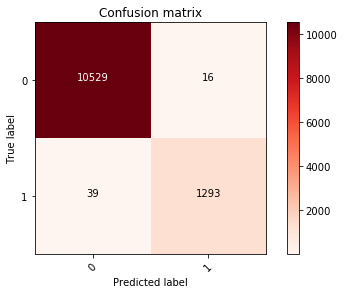

In [29]:
pl.figure()
plot_confusion_matrix(cnf_matrix, classes=n_loan_no_out.loan_status.unique(),
                      cmap=pl.cm.Reds, normalize=False)

In [33]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred.round(), average='binary')

0.97917455509276796